# Permutation-invariant model

In [1]:
import numpy as np
import torch
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import GPT2Model

#############################################
N = 30000
qcd_run_id = "6cdd822e4ff244f1a27c827a2dc20035"
tops_run_id = "5fd3010379144e33a459593892db48a5"
#############################################

path = "/home/df630/SyntheticJets/experiments/results/comet/synthetic-jets"

qcd_gpt2 = GPT2Model.load_from_checkpoint(f"{path}/{qcd_run_id}/checkpoints/best.ckpt")
tops_gpt2 = GPT2Model.load_from_checkpoint(f"{path}/{tops_run_id}/checkpoints/best.ckpt")



INFO: vocab_size: 400, start_token_id: 400
INFO: vocab_size: 400, start_token_id: 400


## Jet generation

In [2]:
prompts = torch.full((N, 1), qcd_gpt2.start_token, dtype=torch.long, device=qcd_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
qcd_jet_seq = generator.predict(qcd_gpt2, dataloaders=prompt_dataloadeer)
qcd_jet_seq = torch.cat(qcd_jet_seq, dim=0)
qcd_jet_bin = qcd_gpt2.synthetic_jets.tokens_to_bins(qcd_jet_seq) 



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
prompts = torch.full((N, 1), tops_gpt2.start_token, dtype=torch.long, device=tops_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
tops_jet_seq = generator.predict(tops_gpt2, dataloaders=prompt_dataloadeer)
tops_jet_seq = torch.cat(tops_jet_seq, dim=0)
tops_jet_bin = tops_gpt2.synthetic_jets.tokens_to_bins(tops_jet_seq) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [7]:
from synthetic_data import SyntheticJets
from utils import kin_plots, ordered_z_plots

qcd = SyntheticJets(shape_param=qcd_gpt2.shape, 
                    scale_param=qcd_gpt2.scale, 
                    bins_z= qcd_gpt2.bins_z,
                    bins_phi=qcd_gpt2.bins_phi,
                    z_order=True,
                    tokenize=True,
                    )

toy_qcd  = qcd.sample(N=N)
toy_qcd = qcd.tokens_to_bins(toy_qcd)

tops = SyntheticJets(shape_param=tops_gpt2.shape, 
                    scale_param=tops_gpt2.scale, 
                    bins_z= tops_gpt2.bins_z,
                    bins_phi=tops_gpt2.bins_phi,
                    z_order=True,
                    tokenize=True,
                    )

toy_tops  = tops.sample(N=N)
toy_tops = tops.tokens_to_bins(toy_tops)

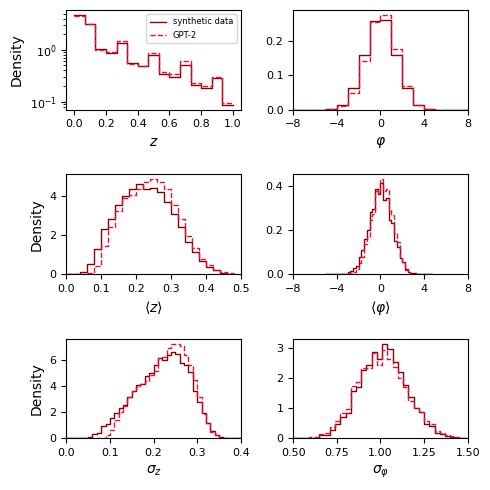

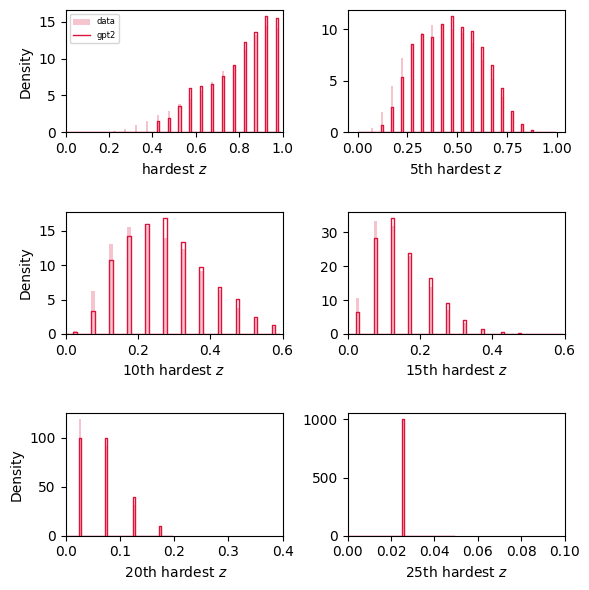

In [8]:
kin_plots(toy_qcd, qcd_jet_bin, "plots/qcd_kin.png")
ordered_z_plots(toy_qcd, qcd_jet_bin)

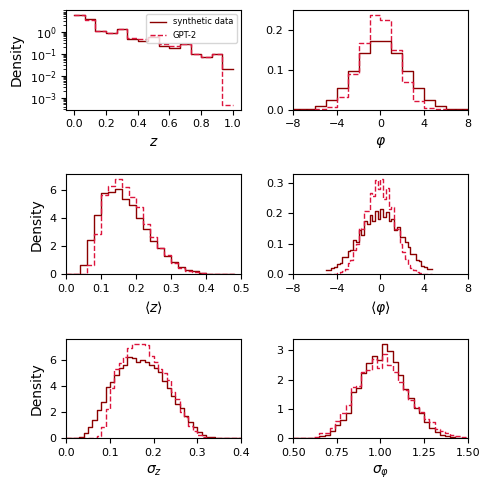

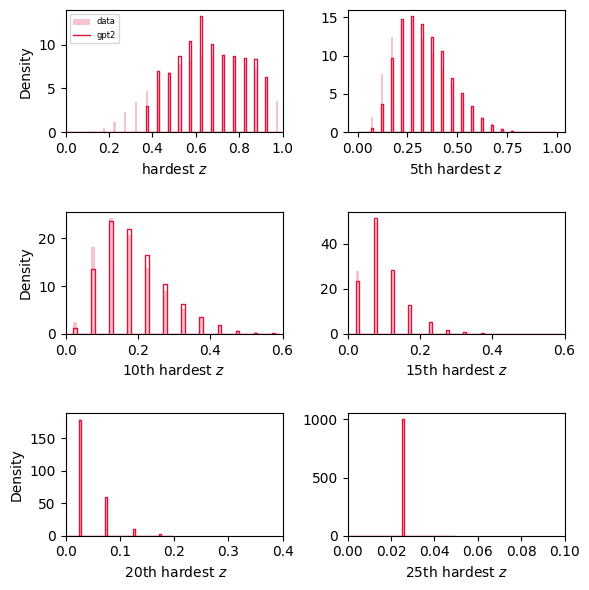

In [9]:
kin_plots(toy_tops, tops_jets_bin, "plots/tops_kin.png")
ordered_z_plots(toy_tops, tops_jets_bin)

## log-likelihood ratio

SyntaxError: invalid syntax (45151265.py, line 1)

(300.0, 400.0)

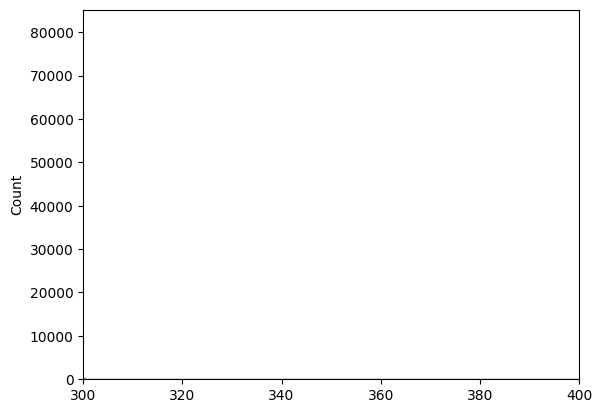

In [39]:
import matplotlib.pyplot as plt

sns.histplot(qcd_jet_seq.flatten(),discrete=True)
sns.histplot(tops_jet_seq.flatten(), discrete=True)
plt.xlim(300, 400)

In [4]:
qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_jet_seq, batch_size=1024)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_jet_seq, batch_size=1024)
tops_logp_on_qcd = tops_gpt2.log_probs(qcd_jet_seq, batch_size=1024)
tops_logp_on_tops = tops_gpt2.log_probs(tops_jet_seq, batch_size=1024)

<Axes: ylabel='Count'>

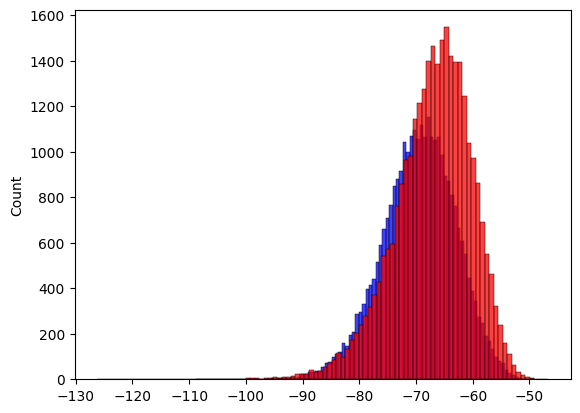

In [10]:
import seaborn as sns

sns.histplot(qcd_logp_on_qcd.cpu().numpy(), bins=100, color="blue", label="qcd_logp_on_qcd")
sns.histplot(qcd_logp_on_tops.cpu().numpy(), bins=100, color="red", label="qcd_logp_on_tops")

In [6]:
def compute_log_likelihood(model, token_sequences, batch_size=256, device="cuda"):
    """
    Compute log-probabilities of tokenized sequences using GPT-2.

    Args:
        model: Trained GPT2Model (LightningModule).
        token_sequences: torch.Tensor of shape (N, D), dtype=torch.long
        batch_size: number of sequences per batch
        device: 'cuda' or 'cpu'

    Returns:
        log_probs: torch.Tensor of shape (N,) — log-probabilities per sequence
    """
    from torch.utils.data import DataLoader, TensorDataset
    import torch.nn.functional as F

    model.eval()
    model.to(device)

    # Add start token
    N, D = token_sequences.shape
    start = torch.full((N, 1), model.start_token, dtype=torch.long, device=device)
    input_ids = torch.cat([start, token_sequences.to(device)], dim=1)  # (N, D+1)

    # Dataset and loader
    dataset = TensorDataset(input_ids)
    loader = DataLoader(dataset, batch_size=batch_size)

    log_probs = []

    with torch.no_grad():
        for (batch,) in loader:
            outputs = model.model(batch, labels=batch)
            # outputs.loss is averaged over all tokens
            # logits: (B, D+1, vocab_size), labels: (B, D+1)
            logits = outputs.logits[:, :-1]         # drop last token prediction
            labels = batch[:, 1:]                   # predict from start to end
            log_probs_batch = -F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                labels.reshape(-1),
                reduction='none'
            ).reshape(batch.size(0), -1).sum(dim=-1)  # sum log-probs per sequence
            log_probs.append(log_probs_batch.cpu())

    return torch.cat(log_probs, dim=0)  # shape (N,)



# import torch
# import numpy as np
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# def plot_likelihood_ratio_roc(llr_qcd, llr_tops):

#     # Labels: 0 = QCD, 1 = Tops
#     llrs = torch.cat([llr_qcd, llr_tops]).numpy()
#     labels = np.concatenate([np.zeros_like(llr_qcd), np.ones_like(llr_tops)])

#     # ROC
#     fpr, tpr, thresholds = roc_curve(labels, llrs)
#     roc_auc = auc(fpr, tpr)

#     plt.figure(figsize=(4, 3))
#     plt.plot(tpr, 1 / fpr, label=f"AUC NP = {roc_auc:.2f}")
#     plt.plot([0, 1], [0, 1], "k--")
#     plt.xlabel("Toy tops efficiency")
#     plt.ylabel("Toy QCD rejection")
#     plt.title("ROC curve")
#     plt.legend()
#     plt.yscale("log")


#     return fpr, tpr, thresholds, llrs, labels


/home/df630/SyntheticJets/utils.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"AUC NP = {roc_auc:.2f}")


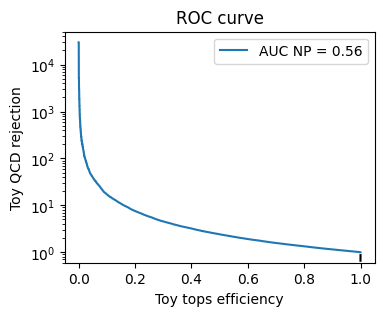

In [6]:
from utils import ROC

# LLR_qcd = qcd_logp_on_tops - qcd_logp_on_qcd    
# LLR_tops = tops_logp_on_tops - tops_logp_on_qcd  

ROC(LLR_qcd, LLR_tops)


In [8]:
import torch
import torch.nn.functional as F

def compute_token_log_probs(model, token_seq, device="cuda"):
    """
    Compute per-token log p(x_t | x_{<t}) for a single sequence.

    Args:
        model: Trained GPT2Model (LightningModule)
        token_seq: torch.Tensor of shape (D,), integer token ids
        device: 'cuda' or 'cpu'

    Returns:
        log_probs: torch.Tensor of shape (D,), per-token log-likelihoods
        preds: torch.Tensor of shape (D,), predicted token ids
    """
    model.eval()
    model.to(device)

    # Add start token to jet sequence
    input_seq = torch.cat([
        torch.tensor([model.start_token], dtype=torch.long, device=device),
        token_seq.to(device)
    ], dim=0).unsqueeze(0)  # shape (1, D+1)

    with torch.no_grad():
        outputs = model.model(input_ids=input_seq)
        logits = outputs.logits  # shape (1, D+1, vocab_size)

        # Shift logits to get target (teacher forcing)
        logits = logits[:, :-1, :]      # shape (1, D, V)
        targets = input_seq[:, 1:]      # shape (1, D)

        log_probs = F.log_softmax(logits, dim=-1)  # shape (1, D, V)
        token_log_probs = log_probs.gather(2, targets.unsqueeze(-1)).squeeze(-1)  # shape (1, D)

    return token_log_probs.squeeze(0).cpu(), torch.argmax(logits, dim=-1).squeeze(0).cpu()


In [18]:
qcd_jets_binned

tensor([[[ 0.9250, -0.5000],
         [ 0.8250,  1.5000],
         [ 0.7750,  1.5000],
         ...,
         [ 0.0250,  1.5000],
         [ 0.0250,  0.5000],
         [ 0.0250,  0.5000]],

        [[ 0.8750,  1.5000],
         [ 0.6250,  1.5000],
         [ 0.5250,  2.5000],
         ...,
         [ 0.0250,  2.5000],
         [ 0.0250,  2.5000],
         [ 0.0250,  1.5000]],

        [[ 0.7750,  1.5000],
         [ 0.5750,  0.5000],
         [ 0.3250, -0.5000],
         ...,
         [ 0.0250,  1.5000],
         [ 0.0250,  2.5000],
         [ 0.0250,  2.5000]],

        ...,

        [[ 0.9750,  1.5000],
         [ 0.9250,  1.5000],
         [ 0.7750,  1.5000],
         ...,
         [ 0.0250,  2.5000],
         [ 0.0250,  0.5000],
         [ 0.0250,  0.5000]],

        [[ 0.5250,  0.5000],
         [ 0.4750, -0.5000],
         [ 0.4250, -0.5000],
         ...,
         [ 0.0250, -3.5000],
         [ 0.0250,  2.5000],
         [ 0.0250,  1.5000]],

        [[ 0.8750, -0.5000],
       

In [ ]:
qcd_seq[0]

In [13]:
qcd_seq[0]

tensor([211, 210, 209, 226, 205, 205, 224, 244, 204, 184, 224, 223, 263, 222,
        221, 201, 201, 241, 221, 221, 201, 221, 220, 220, 180, 220, 200, 200,
        240, 200])

In [52]:

toy_jet = torch.tensor([211, 210, 209, 226, 205, 205, 224, 244, 204, 184, 224, 223, 263, 222,
        221, 201, 201, 241, 221, 221, 201, 221, 220, 220, 180, 220, 200, 200,
        240, 200])
log_probs, preds = compute_token_log_probs(qcd_gpt2, toy_jet)

print("Tokens      :", toy_jet.numpy())
print("Predictions :", preds.numpy())
print("Log probs   :", log_probs.numpy())

Tokens      : [211 210 209 226 205 205 224 244 204 184 224 223 263 222 221 201 201 241
 221 221 201 221 220 220 180 220 200 200 240 200]
Predictions : [218 210 209 208 206 205 205 204 204 203 203 203 203 223 222 221 221 221
 221 221 220 220 220 220 220 220 220 220 220 220]
Log probs   : [-4.1843553 -2.3353882 -2.0094762 -4.0244117 -1.845769  -1.4440348
 -2.1380384 -2.7716331 -1.6390612 -2.707499  -2.4001026 -1.5924855
 -4.4711094 -1.8764718 -2.9722786 -1.2067927 -1.2032279 -2.1247635
 -1.4122312 -1.6075282 -1.9477379 -2.021817  -1.4256278 -1.0526438
 -2.3421159 -1.0998387 -1.1810856 -1.1272875 -1.773839  -1.2054561]


In [11]:
shuffled = qcd_seq[0][torch.randperm(len(qcd_seq[0]))]
log_probs_shuffled, _ = compute_token_log_probs(qcd_gpt2, shuffled)
print("Total log p (original) :", log_probs.sum().item())
print("Total log p (shuffled) :", log_probs_shuffled.sum().item())



Total log p (original) : -61.14411163330078
Total log p (shuffled) : -188.78878784179688


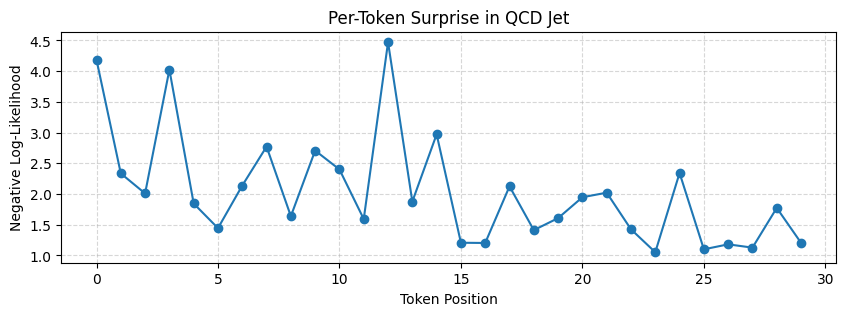

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(-log_probs.numpy(), marker="o")
plt.xlabel("Token Position")
plt.ylabel("Negative Log-Likelihood")
plt.title("Per-Token Surprise in QCD Jet")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [20]:
def token_id(i,j):
    return i+30*j

In [33]:
token_id(8,9), token_id(11,4)

(278, 131)

In [43]:
30*7 + 0, 30*7 + 1

(210, 211)